# EEG Data Analysis for Bayesian Updating

First import the data for only one condition (explicit with a prior probability of .8)

In [2]:
%matplotlib inline
from helper_functions import *

import pystan
import mne
#import re
import matplotlib.colors as colors
from functools import partial
import os
import pystan
import pandas as pd
from math import fsum
from scipy.io import loadmat
import scipy.stats
from sklearn.decomposition import FastICA
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV,RidgeCV,Ridge,BayesianRidge
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVR,NuSVR
from scipy.fftpack import fft

chan_list = np.array(["Fp1","Fp2","F7","F3","Fz","F4","F8","FC5","FC1","FC2","FC6","T7","C3","Cz","C4","T8","CP5","CP1","CP2","CP6","P7","P3","Pz","P4","P8","TP9","TP10","Oz","O2","O1"])

#These can and should later be estimated in an overall model
gammas_exp80 = np.array([2.9,2.5,2.0,2.2,2.5,1.7,3.8,3.1,3.8,2.6,3.0,3.9,1.9,3.9,1.7,1.6]).T
#pnull in log-odds
pnull_exp80 = np.array([-1.5,-1.6,-1.9,0.2,-0.8,-1.8,-1.0,0.8,-1.6,-2.4,-2.5,-1.0,-2.4,-1.0,-0.2,-1.5]).T
#now you can transform the bc_dict values for every person



In [4]:
#alternative for kolossa model
#These can and should later be estimated in an overall model
gammas_exp80_kolossa = np.array([0.74 for t in xrange(16)]).T
#pnull in log-odds
pnull_exp80_kolossa = np.array([0 for t in xrange(16)]).T
#now you can transform the bc_dict values for every person

In [155]:
#alternative for kolossa model
#These can and should later be estimated in an overall model
gammas_exp80_kolossa = np.array([0.88 for t in xrange(16)]).T
#pnull in log-odds
pnull_exp80_kolossa = np.array([4.0 for t in xrange(16)]).T
#now you can transform the bc_dict values for every person

In [3]:
likelihood = { 1 : 0.3, 2: 0.7 }
prior = 0.2

path = "/home/mboos/Work/Bayesian Updating/Data/"
path_mat = "/home/mboos/Work/Bayesian Updating/Data EEG/"

files = os.listdir(path)
mat_files = os.listdir(path_mat)

pattern_TS = "80exp"
pattern = "exp80"

bc_dict = dict()
mat_dict = dict()
brar_dict = dict()

#%%
#strip VEOH,HEOG electrodes

#100ms BEFORE stimulus presentation


for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        bclass = get_bclass(fn,prior,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,25:,:])
        if curr.shape[2] != sum(bclass[:,0]>0):
            continue
        mat_dict[fn[4:6]] = curr[:,:,(f_ep[bclass[:,0]>0])==1]
        bc_dict[fn[4:6]] = bclass[f_ep==1,1]
        brar_dict[fn[4:6]] = bclass[f_ep==1,0]

        

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### For last two balls

In [2]:
#for last two balls!

likelihood = { 1 : 0.3, 2: 0.7 }
prior = 0.2

path = "/home/mboos/Work/Bayesian Updating/Data/"
path_mat = "/home/mboos/Work/Bayesian Updating/Data EEG/"

files = os.listdir(path)
mat_files = os.listdir(path_mat)

pattern_TS = "80exp"
pattern = "exp80"

bc_dict = dict()
mat_dict = dict()
brar_dict = dict()

#%%
#strip VEOH,HEOG electrodes

#100ms BEFORE stimulus presentation


for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        bclass = get_bclass(fn,prior,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,25:,:])
        if curr.shape[2] != sum(bclass[:,0]>0):
            continue
        mat_dict[fn[4:6]] = curr[:,:,np.logical_and((f_ep[bclass[:,0]>0])==1,np.tile([0,0,1,1],f_ep.size/4)[bclass[:,0]>0]==1)]
        bc_dict[fn[4:6]] = bclass[np.logical_and(f_ep==1,np.tile([0,0,1,1],f_ep.size/4)==1),1]
        brar_dict[fn[4:6]] = bclass[np.logical_and(f_ep==1,np.tile([0,0,1,1],f_ep.size/4)==1),0]

        

## Different probability representations

In [5]:
#Kullback-Leibler divergence
nbin = 1#doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
kld_dict = dict()
f_ep_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep_dict[fn[4:6]] = get_failed_epochs(fn)
        f_ep = f_ep_dict[fn[4:6]]
        kld = kld_vec(fn,prior,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(kld[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        kld_dict[fn[4:6]] = kld[f_ep==1,1]

#Distorted log-odds
dbc_dict = {}
for k in bc_dict.keys():
    dbc_dict[k] = bc_dict[k]*gammas_exp80[int(k)-1] + pnull_exp80[int(k)-1]*(1-gammas_exp80[int(k)-1])

        
#Predictive Surprise
nbin = 1 #doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
predictive_surprise_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        predsurp = predictive_surprise_vec(fn,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(predsurp[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        predictive_surprise_dict[fn[4:6]] = predsurp[f_ep==1,1]



#distorted Kullback-Leibler divergence
nbin = 1 #doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
kld_dist_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        kld = kld_vec_distort(fn,prior,likelihood,gammas_exp80[int(fn[4:6])-1],pnull_exp80[int(fn[4:6])-1])
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(kld[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        kld_dist_dict[fn[4:6]] = kld[f_ep==1,1]

#distorted log-odds as in Kolossa et al.
nbin = 1
kdist_dict = dict()
blist_dict = dict()

#first get this as list representation
for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        bclass = get_bclass_list(fn,prior,likelihood)
        bcl1 = get_bclass(fn,prior,likelihood)
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(bcl1[:,0]>0):
            continue
        brar_dict[fn[4:6]] = bcl1[:,0]
        blist_dict[fn[4:6]] = bclass

 
for pb in sorted(blist_dict.keys()):
    for i,e in enumerate(blist_dict[pb]):
        blist_dict[pb][i][0] = e[0] + e[1]
        blist_dict[pb][i].pop(1)
        blist_dict[pb][i] = [0 for t in xrange(4-len(blist_dict[pb][i]))] + blist_dict[pb][i]

for key in sorted(blist_dict.keys()):
    kdist_dict[key] = np.array(blist_dict[key])
    kdist_dict[key] = kdist_dict[key].dot(np.array([gammas_exp80_kolossa[int(key)-1]**i for i in reversed(xrange(1,5))]))


kld_kdist_dict = dict()
for key in sorted(kdist_dict.keys()):
    kld_kdist_dict[key] = np.concatenate([np.array([discrete_kld(*logist(row)) for row in rolling_window(np.append(gammas_exp80_kolossa[int(key)-1]*np.log(prior/(1-prior)),e),2)]) for e in np.reshape(kdist_dict[key],(50,4))])
    
for key in kdist_dict.keys():
    kdist_dict[key] = kdist_dict[key][f_ep_dict[key]==1]
    kld_kdist_dict[key] = kld_kdist_dict[key][f_ep_dict[key]==1]


NameError: name 'gammas_exp80_kolossa' is not defined

### For last two balls

In [3]:
#Kullback-Leibler divergence
nbin = 1#doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
kld_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        kld = kld_vec(fn,prior,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(kld[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        kld_dict[fn[4:6]] = kld[np.logical_and(f_ep==1,np.tile([0,0,1,1],f_ep.size/4)==1),1]

#Distorted log-odds
dbc_dict = {}
for k in bc_dict.keys():
    dbc_dict[k] = bc_dict[k]*gammas_exp80[int(k)-1] + pnull_exp80[int(k)-1]*(1-gammas_exp80[int(k)-1])

        
#Predictive Surprise
nbin = 1 #doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
predictive_surprise_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        predsurp = predictive_surprise_vec(fn,likelihood)
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(predsurp[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        predictive_surprise_dict[fn[4:6]] = predsurp[np.logical_and(f_ep==1,np.tile([0,0,1,1],f_ep.size/4)==1),1]



#distorted Kullback-Leibler divergence
nbin = 1 #doesnt matter, curr isnt used, only to ensure that we have an estimate of the number of epochs 
kld_dist_dict = dict()

for fn in files:
    if fn.startswith("TS") and pattern_TS in fn:
        f_ep = get_failed_epochs(fn)
        kld = kld_vec_distort(fn,prior,likelihood,gammas_exp80[int(fn[4:6])-1],pnull_exp80[int(fn[4:6])-1])
        #re-reference and average over k bins
        #also think about better way to ensure the result is unique!
        curr = k_bin_average(rereference(loadmat(path_mat+filter(lambda x : fn[4:6] in x and pattern in x and "epochs" in x,mat_files)[0])["EEGdata"][:30,50:,:]),nbin)
        if curr.shape[2] != sum(kld[:,0]>0):
            continue
        if f_ep.size % 4 != 0:
            print "error at " + fn
            break
        kld_dist_dict[fn[4:6]] = kld[np.logical_and(f_ep==1,np.tile([0,0,1,1],f_ep.size/4)==1),1]


helper_functions.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return lo*gamma + pnull*(1-gamma)


## Visualization of ERPs per probability

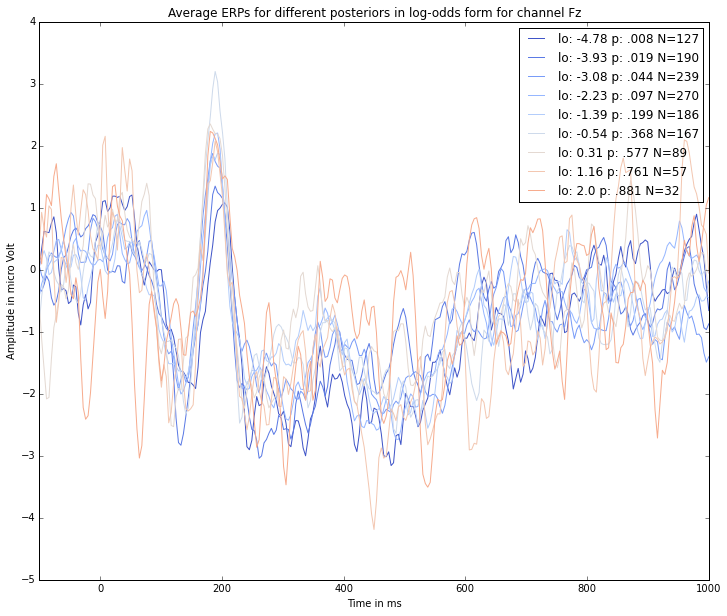

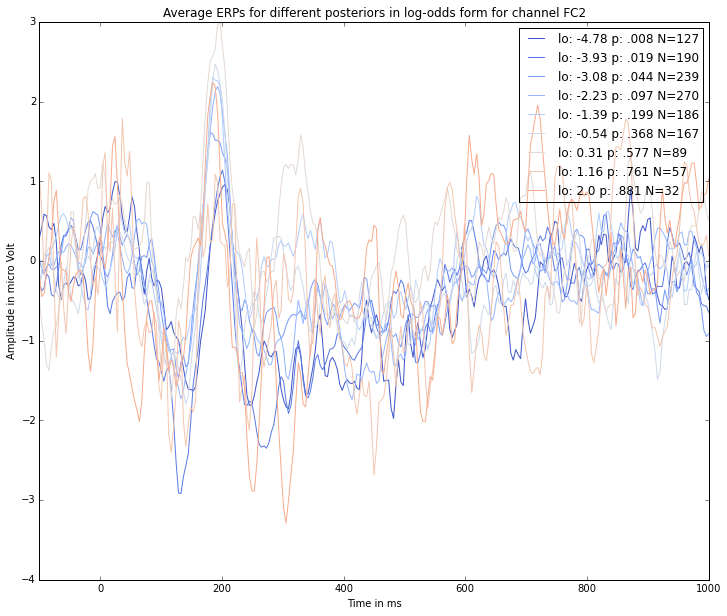

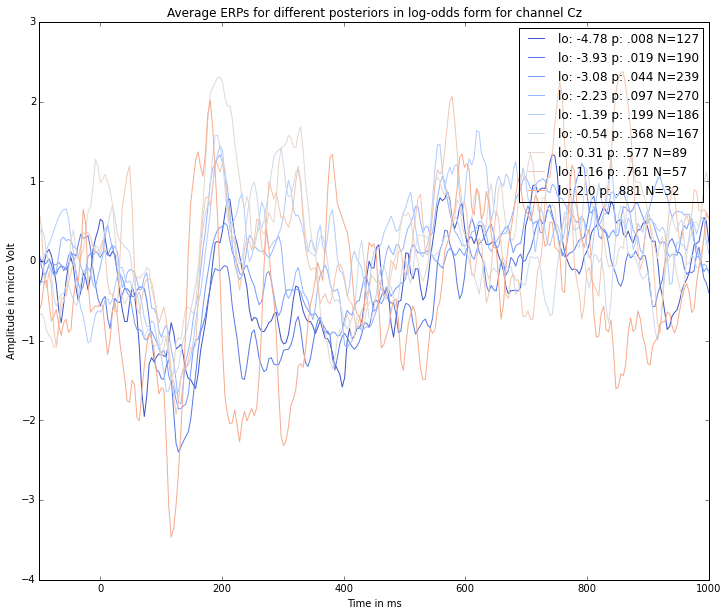

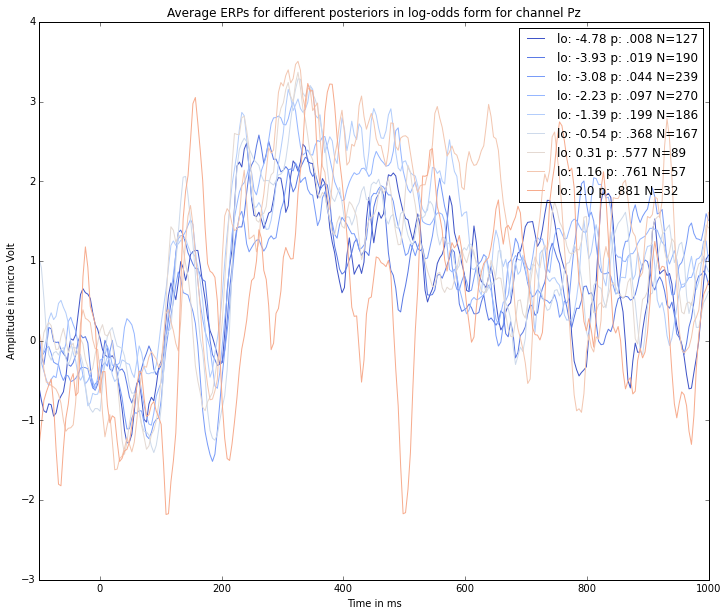

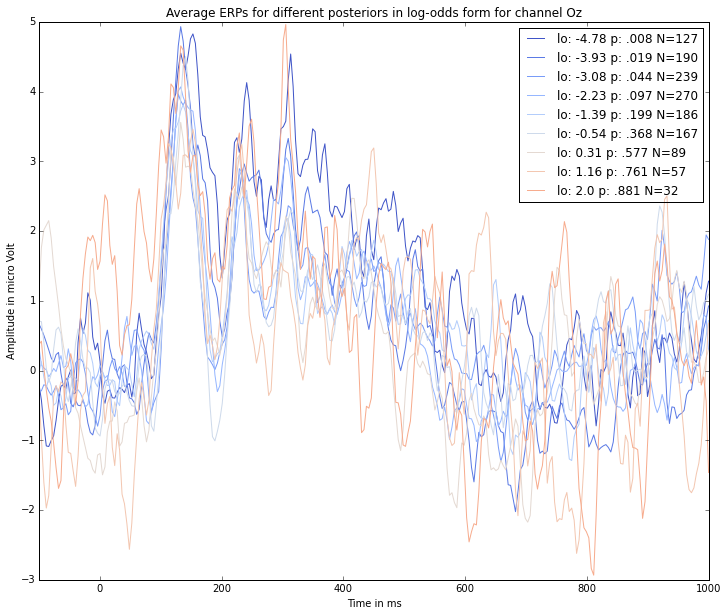

In [4]:
posteriors = np.unique(np.round(bc_dict["01"],decimals=2))

avr_ERP_p_post_list = [get_average_ERPs_per_posterior(mat_dict[k],bc_dict[k],chan=4) for k in sorted(mat_dict.keys())] 

ERP_p_post = np.array([np.mean([pb[n,:] for pb in avr_ERP_p_post_list if pb.shape[0] > n ],axis=0) for n,posterior in enumerate(posteriors) ])

interesting_ones = ['Fz','FC2','Cz','Pz','Oz']
posteriors = np.unique(np.round(bc_dict["01"],decimals=2))
posterior_N = [ np.sum(np.sum(np.round(bc_dict[k],decimals=2) == p) for k in bc_dict.keys()) for p in posteriors  ]


for channel in interesting_ones:
    avr_ERP_p_post_list = [get_average_ERPs_per_posterior(mat_dict[k],bc_dict[k],chan=np.where(chan_list==channel)[0]) for k in sorted(mat_dict.keys())] 
    ERP_p_post = np.array([np.mean([pb[n,:] for pb in avr_ERP_p_post_list if pb.shape[0] > n ],axis=0) for n,posterior in enumerate(posteriors) ])
    
    
    #plot it
    coolwarm = plt.get_cmap('coolwarm')
    nm = colors.Normalize(vmin=-5,vmax=5)
    scm_cm = plt.cm.ScalarMappable(norm=nm,cmap=coolwarm)
    
    fig = plt.figure()
    fig.set_size_inches(12,10)
    plt.hold(True)
    for i,post in enumerate(posteriors):
        #cval = (post-np.min(posteriors))/(np.max(posteriors)-np.min(posteriors))
        plt.plot(np.linspace(-100,1000,ERP_p_post.shape[1]),ERP_p_post[i,:],c=scm_cm.to_rgba(post))
    plt.xlim(-100,1000)
    plt.xlabel('Time in ms')
    plt.ylabel('Amplitude in micro Volt')
    plt.title('Average ERPs for different posteriors in log-odds form for channel ' + channel)
    plt.legend(map(lambda x : "lo: " + str(x[0]) + " p: " + str(np.round(logist(x[0]),decimals=3))[1:] + " N="+str(x[1]),zip(posteriors,posterior_N)))



## Visualization of ERPs per KLD

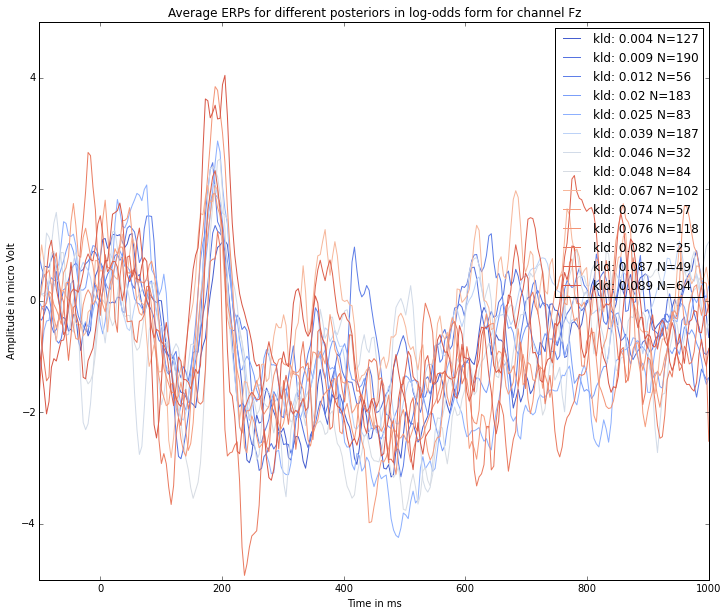

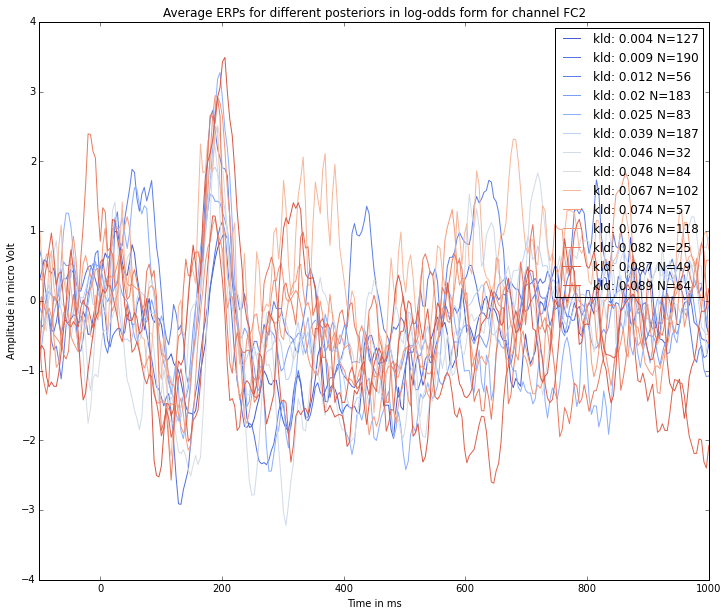

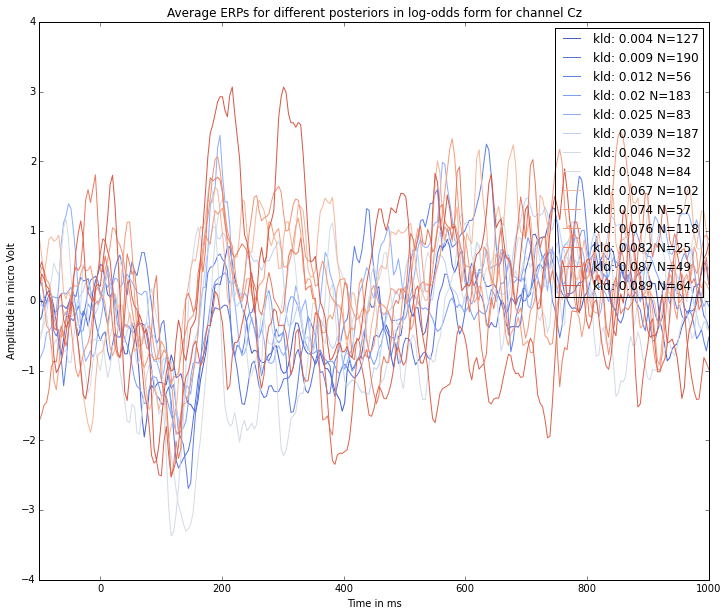

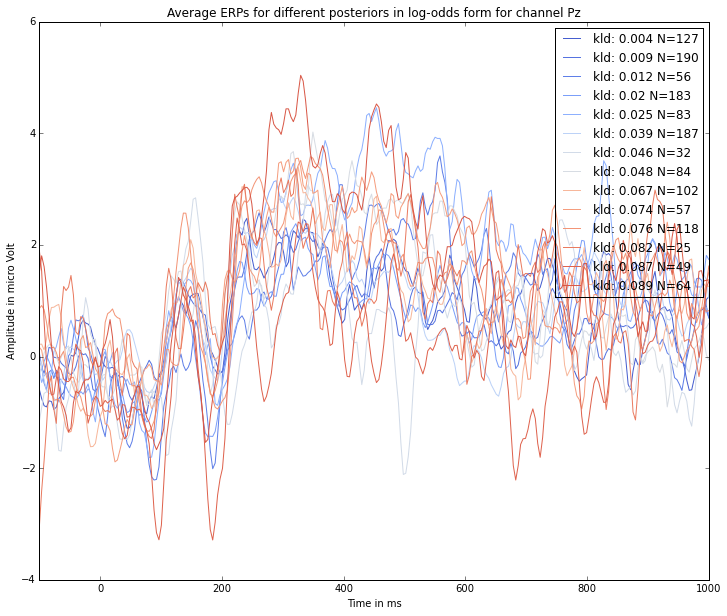

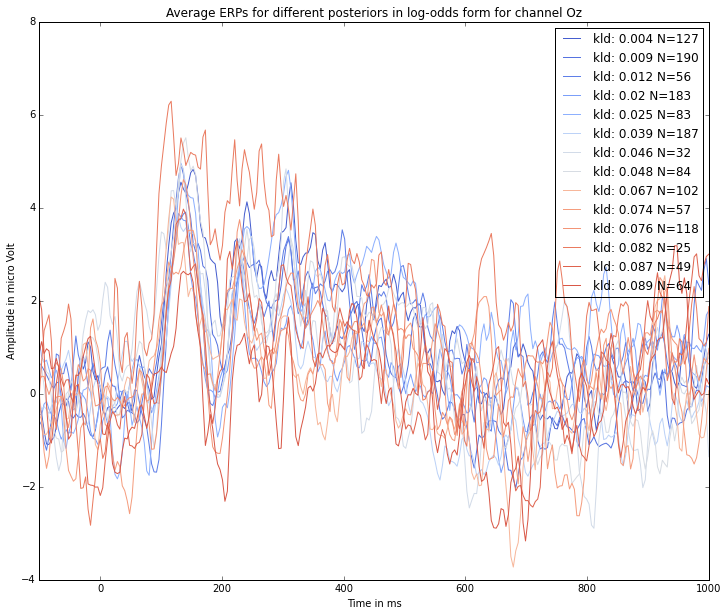

In [5]:

#interesting_ones = ['Fz','FCz','Cz','Pz','Oz']
klds = np.unique(np.round(kld_dict["01"],decimals=3))
kld_dict = { k : np.round(kld_dict[k],decimals=3) for k in sorted(kld_dict.keys())} 
kld_N = [ np.sum(np.sum(np.round(kld_dict[k],decimals=3) == p) for k in kld_dict.keys()) for p in klds  ]


for channel in interesting_ones:
    avr_ERP_p_kld_list = [ np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,kld_dict[k]==i],axis=0) for i in np.unique(kld_dict[k]) ]) for k in sorted(mat_dict.keys())] 
    ERP_p_kld = np.array([np.mean([pb[n,:] for pb in avr_ERP_p_kld_list if pb.shape[0] > n ],axis=0) for n,kld in enumerate(klds) ])
    
    
    #plot it
    coolwarm = plt.get_cmap('coolwarm')
    nm = colors.Normalize(vmin=0,vmax=0.1)
    scm_cm = plt.cm.ScalarMappable(norm=nm,cmap=coolwarm)
    
    fig = plt.figure()
    fig.set_size_inches(12,10)
    plt.hold(True)
    for i,kld in enumerate(klds):
        plt.plot(np.linspace(-100,1000,ERP_p_kld.shape[1]),ERP_p_kld[i,:],c=scm_cm.to_rgba(kld))
    plt.xlim(-100,1000)
    plt.xlabel('Time in ms')
    plt.ylabel('Amplitude in micro Volt')
    plt.title('Average ERPs for different posteriors in log-odds form for channel ' + channel)
    plt.legend(map(lambda x : "kld: " + str(x[0]) + " N=" + str(x[1]),zip(klds,kld_N)))

## GLM mapping of probabilites onto the ERPs

In [6]:
interesting_ones = ['Fz','FC2','Cz','Pz','Oz']
avr_ERP_p_post_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],bc_dict[k],chan=np.where(chan_list==channel)[0])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]

#%%
#get rid of n < 4 values
avr_ERP_p_post_list = [ERPs[[nr for nr,p in enumerate(np.unique(np.round(bc_dict[sorted(bc_dict.keys())[nerp]],decimals=2))) if np.sum(np.round(bc_dict[sorted(bc_dict.keys())[nerp]],decimals=2) == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_post_list)]

#create corresponding y
y = np.concatenate([[p for p in np.unique(np.round(bc_dict[k],decimals=2)) if np.sum(np.round(bc_dict[k],decimals=2) == p) >= 4  ] for k in sorted(bc_dict.keys())])
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_post_list,axis=0)

y_st = np.concatenate([bc_dict[key] for key in sorted(bc_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])

ralpha = 0.000001

### Correlations/Regression for ERPs with undistorted (log-odds) probabilites

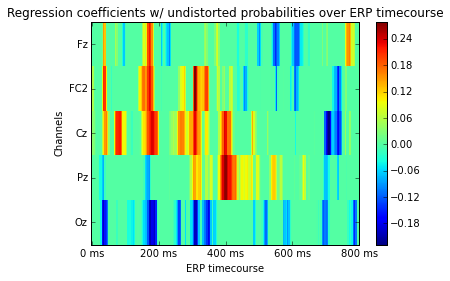

In [138]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_scaled[:,None],xnow).coef_ for xnow in X_scaled.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ undistorted probabilities over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_unverzerrte_lo_probs.tif')

### Single-Trial Regressions/Correlations with undistorted (log-odds) probabilities

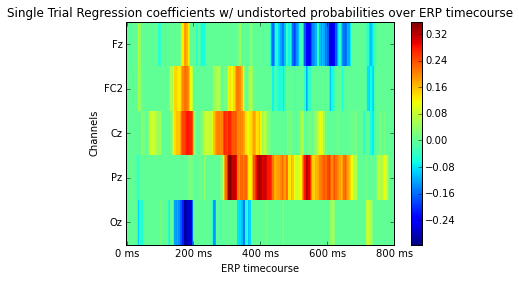

In [139]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single Trial {} coefficients w/ undistorted probabilities over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_unverzerrte_lo_probs.tif')

### Correlations with distorted (log-odds) probabilities

In [140]:
avr_ERP_p_post_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],dbc_dict[k],chan=np.where(chan_list==channel)[0])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]

#%%
#get rid of n < 4 values
avr_ERP_p_post_list = [ERPs[[nr for nr,p in enumerate(np.unique(np.round(dbc_dict[sorted(dbc_dict.keys())[nerp]],decimals=2))) if np.sum(np.round(dbc_dict[sorted(dbc_dict.keys())[nerp]],decimals=2) == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_post_list)]

#create corresponding y
y = np.concatenate([[p for p in np.unique(np.round(dbc_dict[k],decimals=2)) if np.sum(np.round(dbc_dict[k],decimals=2) == p) >= 4  ] for k in sorted(dbc_dict.keys())])
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_post_list,axis=0)


y_st = np.concatenate([dbc_dict[key] for key in sorted(dbc_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])


ralpha = 0.000001

### Correlations/Regressions for average ERPs with distorted probabilities

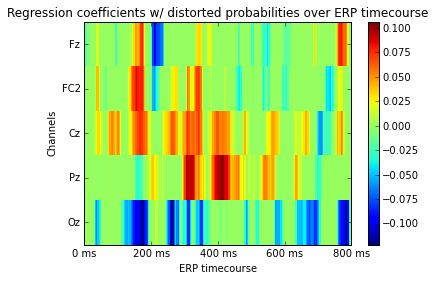

In [141]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y[:,None],xnow).coef_ for xnow in X.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ distorted probabilities over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_verzerrte_lo_probs.tif')

### Single Trial Correlations/Regression with distorted probabilities

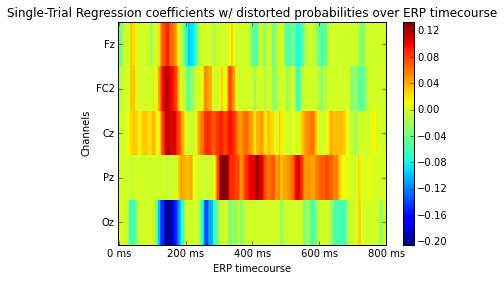

In [142]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single-Trial {} coefficients w/ distorted probabilities over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('singletrial_verzerrte_lo_probs.tif')

### Correlations with distorted Log-Odds (as in Kolossa et al.)

In [157]:
#list of participants, each entry the concatenated timecourses from 0 to 800 ms (4 ms sampling, no time binning)
avr_ERP_p_kdist_list = [ np.concatenate([np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,kdist_dict[k]==i],axis=0) for i in np.unique(kdist_dict[k]) ])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())] 

#avr_ERP_p_kld_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],kld_dict[k],chan=np.where(chan_list==channel)[0])[:,50:] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]
#%%
#get rid of n < 4 values
avr_ERP_p_kdist_list = [ERPs[[nr for nr,p in enumerate(np.unique(kdist_dict[sorted(kdist_dict.keys())[nerp]])) if np.sum(kdist_dict[sorted(kdist_dict.keys())[nerp]] == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_kdist_list)]


#%%
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_kdist_list,axis=0)

#create corresponding y
y = np.concatenate([[p for p in np.unique(kdist_dict[k]) if np.sum(kdist_dict[k]== p) >= 4] for k in sorted(kdist_dict.keys())])


y_st = np.concatenate([kdist_dict[key] for key in sorted(kdist_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])



### Kolossa et al. distorted probabilities for average ERPs

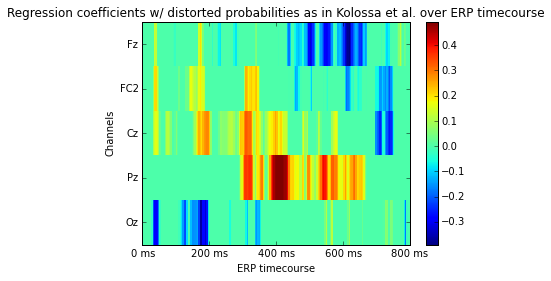

In [158]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y[:,None],xnow).coef_ for xnow in X.T],(5,200))



plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ distorted probabilities as in Kolossa et al. over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_verzerrte_lo_probabilities_Kolossa_mit_p0.tif')

### Kolossa et al. distorted probabilities for Single Trial ERPs

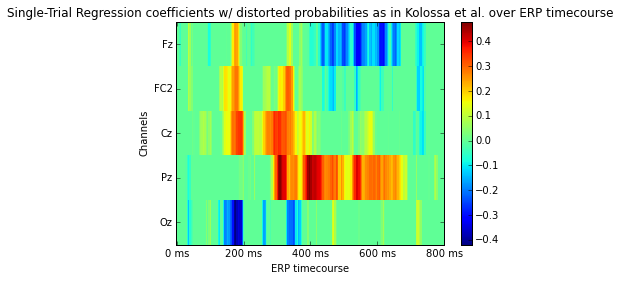

In [159]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single-Trial {} coefficients w/ distorted probabilities as in Kolossa et al. over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('singletrial_verzerrte_lo_probs_Kolossa_mit_p0.tif')

### Correlations with KL-divergences

In [146]:
#list of participants, each entry the concatenated timecourses from 0 to 800 ms (4 ms sampling, no time binning)
avr_ERP_p_kld_list = [ np.concatenate([np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,kld_dict[k]==i],axis=0) for i in np.unique(kld_dict[k]) ])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())] 

#avr_ERP_p_kld_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],kld_dict[k],chan=np.where(chan_list==channel)[0])[:,50:] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]
#%%
#get rid of n < 4 values
avr_ERP_p_kld_list = [ERPs[[nr for nr,p in enumerate(np.unique(kld_dict[sorted(kld_dict.keys())[nerp]])) if np.sum(kld_dict[sorted(kld_dict.keys())[nerp]] == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_kld_list)]


#%%
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_kld_list,axis=0)

#create corresponding y
y = np.concatenate([[p for p in np.unique(kld_dict[k]) if np.sum(kld_dict[k]== p) >= 4] for k in sorted(kld_dict.keys())])


y_st = np.concatenate([kld_dict[key] for key in sorted(kld_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])



### Correlation/Regression coefficients for undistorted KLDs over average ERPs

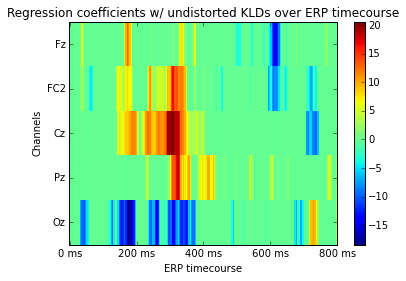

In [147]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y[:,None],xnow).coef_ for xnow in X.T],(5,200))



plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ undistorted KLDs over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_unverzerrte_KLDs.tif')

### Single Trial Correlation/Regression coefficients for undistorted KLDs

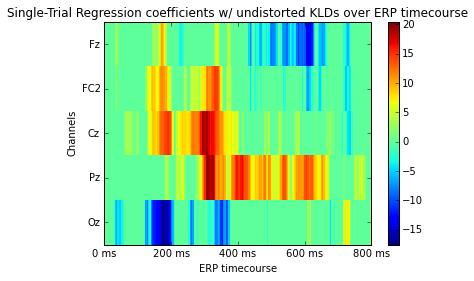

In [148]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single-Trial {} coefficients w/ undistorted KLDs over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('singletrial_unverzerrte_KLDs.tif')

### Correlation with Distorted KLDs

In [149]:
#list of participants, each entry the concatenated timecourses from 0 to 800 ms (4 ms sampling, no time binning)
avr_ERP_p_kld_list = [ np.concatenate([np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,kld_dist_dict[k]==i],axis=0) for i in np.unique(kld_dist_dict[k]) ])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())] 

#avr_ERP_p_kld_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],kld_dict[k],chan=np.where(chan_list==channel)[0])[:,50:] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]
#%%
#get rid of n < 4 values
avr_ERP_p_kld_list = [ERPs[[nr for nr,p in enumerate(np.unique(kld_dist_dict[sorted(kld_dist_dict.keys())[nerp]])) if np.sum(kld_dist_dict[sorted(kld_dist_dict.keys())[nerp]] == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_kld_list)]


#%%
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_kld_list,axis=0)

#create corresponding y
y = np.concatenate([[p for p in np.unique(kld_dist_dict[k]) if np.sum(kld_dist_dict[k]== p) >= 4] for k in sorted(kld_dist_dict.keys())])


y_st = np.concatenate([kld_dist_dict[key] for key in sorted(kld_dist_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])



### Correlation/Regression Coefficients for distorted KLDs over ERP timecourse

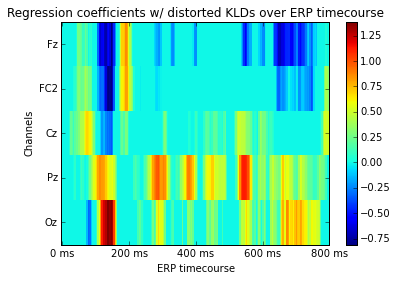

In [150]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y[:,None],xnow).coef_ for xnow in X.T],(5,200))



plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ distorted KLDs over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_verzerrte_KLDs.tif')

### Single Trial Correlation/Regression Coefficients for distorted KLDs

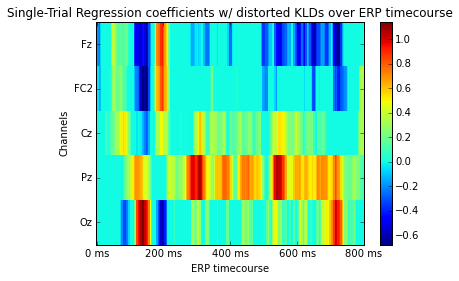

In [151]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single-Trial {} coefficients w/ distorted KLDs over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('singletrial_verzerrte_KLDs.tif')

### Distorted KLDs as in Kolossa et al.

In [160]:
#list of participants, each entry the concatenated timecourses from 0 to 800 ms (4 ms sampling, no time binning)
avr_ERP_p_kld_kdist_list = [ np.concatenate([np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,kld_kdist_dict[k]==i],axis=0) for i in np.unique(kld_kdist_dict[k]) ])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())] 

#avr_ERP_p_kld_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],kld_dict[k],chan=np.where(chan_list==channel)[0])[:,50:] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]
#%%
#get rid of n < 4 values
avr_ERP_p_kld_kdist_list = [ERPs[[nr for nr,p in enumerate(np.unique(kld_kdist_dict[sorted(kld_kdist_dict.keys())[nerp]])) if np.sum(kld_kdist_dict[sorted(kld_kdist_dict.keys())[nerp]] == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_kld_kdist_list)]


#%%
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_kld_kdist_list,axis=0)

#create corresponding y
y = np.concatenate([[p for p in np.unique(kld_kdist_dict[k]) if np.sum(kld_kdist_dict[k]== p) >= 4] for k in sorted(kld_kdist_dict.keys())])


y_st = np.concatenate([kld_kdist_dict[key] for key in sorted(kld_kdist_dict.keys())])
X_st = np.vstack([ np.reshape(np.swapaxes(np.swapaxes(mat_dict[key][:,25:-50,:],0,2),1,2)[:,[np.where(chan_list==channel)[0][0] for channel in interesting_ones],:],(-1,1000)) for key in sorted(mat_dict.keys()) ])



### Correlation/Regression coefficients for distorted KLDs as in Kolossa et al. over average ERPs

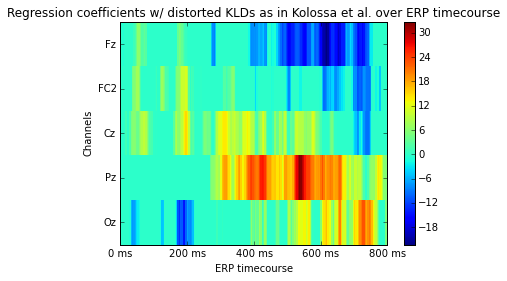

In [161]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y[:,None],xnow).coef_ for xnow in X.T],(5,200))



plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('{} coefficients w/ distorted KLDs as in Kolossa et al. over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('avr_ERP_verzerrte_KLDs_Kolossa_mit_p0.tif')

### Single-Trial Correlation/Regression coefficients for distorted KLDs as in Kolossa et al. 

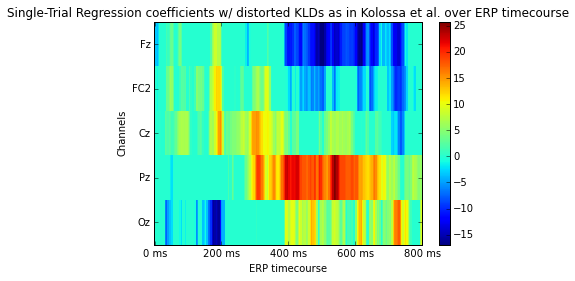

In [162]:
correlate = False
normalize = True

if correlate:
    coefs = np.reshape([ scipy.stats.pearsonr(y_st,xnow)[0] for xnow in X_st.T],(5,200))
else:
    coefs = np.reshape([BayesianRidge(normalize=normalize).fit(y_st[:,None],xnow).coef_ for xnow in X_st.T],(5,200))


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Single-Trial {} coefficients w/ distorted KLDs as in Kolossa et al. over ERP timecourse'.format({True:'Correlation' , False:'Regression'}[correlate]))
plt.savefig('singletrial_verzerrte_KLDs_Kolossa_mit_p0.tif')

### Predictive Surprise

In [14]:
#list of participants, each entry the concatenated timecourses from 0 to 800 ms (4 ms sampling, no time binning)
avr_ERP_p_predictive_list = [ np.concatenate([np.array([ np.mean(mat_dict[k][np.where(chan_list==channel)[0],:,predictive_surprise_dict[k]==i],axis=0) for i in np.unique(predictive_surprise_dict[k]) ])[:,25:-50] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())] 

#avr_ERP_p_kld_list = [np.concatenate([get_average_ERPs_per_posterior(mat_dict[k],kld_dict[k],chan=np.where(chan_list==channel)[0])[:,50:] for channel in interesting_ones],axis=1) for k in sorted(mat_dict.keys())]
#%%
#get rid of n < 4 values
avr_ERP_p_predictive_list = [ERPs[[nr for nr,p in enumerate(np.unique(predictive_surprise_dict[sorted(predictive_surprise_dict.keys())[nerp]])) if np.sum(predictive_surprise_dict[sorted(predictive_surprise_dict.keys())[nerp]] == p) >= 4 ],:] for nerp,ERPs in enumerate(avr_ERP_p_predictive_list)]


#%%
#now concatenate on axis of posteriors
X = np.concatenate(avr_ERP_p_predictive_list,axis=0)

#create corresponding y
y = np.concatenate([[p for p in np.unique(predictive_surprise_dict[k]) if np.sum(predictive_surprise_dict[k]== p) >= 4] for k in sorted(predictive_surprise_dict.keys())])


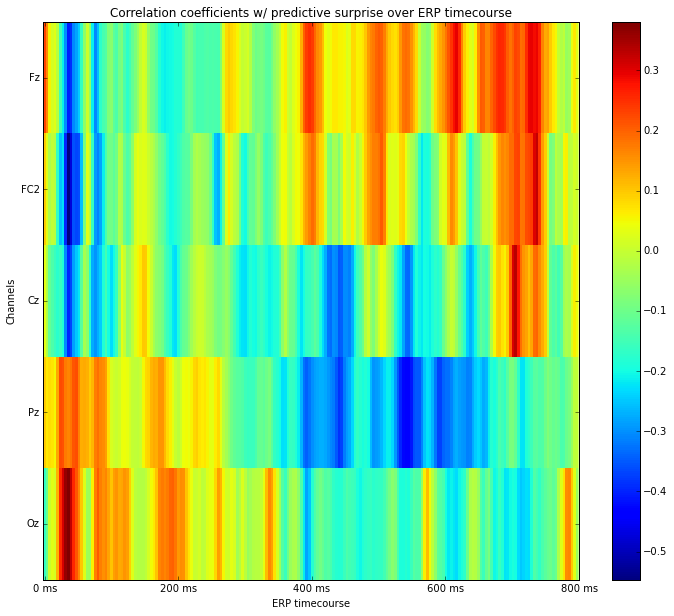

In [15]:
coefs = np.reshape([ scipy.stats.pearsonr(y,xnow)[0] for xnow in X.T],(5,200))
fig = plt.figure()
fig.set_size_inches(12,10)


plt.imshow(coefs,aspect='auto',interpolation='nearest')
plt.xticks([0,50,100,150,200],['0 ms','200 ms','400 ms','600 ms','800 ms'])
plt.yticks([0,1,2,3,4],interesting_ones)
plt.colorbar()
plt.xlabel('ERP timecourse')
plt.ylabel('Channels')
plt.title('Correlation coefficients w/ predictive surprise over ERP timecourse')
#plt.savefig('predictive_surprise_correlation_with_ERP.tif')

## Common Spatial Patterns

This does not seem to work and is probably futile.

In [37]:
#get 0 and 1 ball labels
ball_labels = np.concatenate([brar_dict[k] for k in sorted(brar_dict.keys())])
#see if this improves with more or less components
n_components = 4


conc_epoch_data = np.concatenate([ np.swapaxes(np.swapaxes(mat_dict[k],0,2),1,2) for k in sorted(mat_dict.keys())],axis=0)

In [38]:
#for now with only difference being rare or common ball
csp = mne.decoding.CSP(n_components=n_components,reg='lws')
csp.fit(conc_epoch_data,ball_labels)

In [39]:
layout = mne.layouts.read_layout(path_mat+'1020_reco_layout.lay')
evoked = mne.EvokedArray(data=csp.patterns_.T,info=mne.create_info(ch_names=list(chan_list),sfreq=250,ch_types=['eeg']*30),tmin=0)
evoked.times = np.arange(evoked.data.shape[0])

/home/mboos/anaconda/lib/python2.7/site-packages/mne/utils.py:487: DeprecationWarning: Function read_layout is deprecated; The module ``mne.layouts`` is deprecated and will be removed in MNE-Python 0.10. Please import ``read_layout`` from ``mne.channels``
  warnings.warn(msg, category=DeprecationWarning)


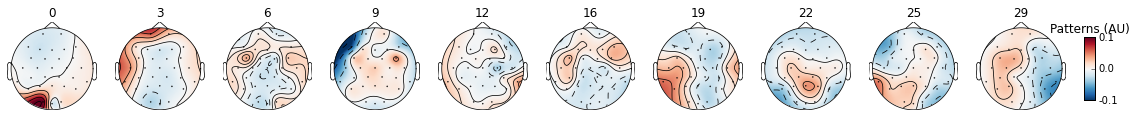

In [40]:
evoked.plot_topomap(ch_type='eeg', layout=layout,
                    scale_time=1, time_format='%i', scale=1,
                    unit='Patterns (AU)', size=1.5)
sources = csp.transform(conc_epoch_data)
conc_kld = np.concatenate([kld_dict[k] for k in sorted(kld_dict.keys())])
lop_conc = np.concatenate([bc_dict[k] for k in sorted(bc_dict.keys())])
kld_source_corrs = [scipy.stats.pearsonr(conc_kld,xnow) for xnow in sources.T]
lop_source_corrs = [scipy.stats.pearsonr(lop_conc,xnow) for xnow in sources.T]

## Bayesian Model - the simplest

Replicate the Ridge & Correlation Results from above with a Bayesian model

In [37]:
eeg_encoding_model_average_ERP = """
data {

int<lower=0> n_features;
int<lower=0> n_units;

//more efficient?
real ERP[n_units,n_features];
 
vector[n_units] IV;
}
parameters {
//more efficient?
vector[n_features] p_vec;
//define variance
real<lower=0> sigma;

}
model {

sigma ~ inv_gamma(1,1);


//prior here, probably normal
for (i in 1:n_features)
    p_vec[i] ~ normal(0,4);


for (i in 1:n_features)
    for (p in 1:n_units)
        ERP[p,i] ~ normal(IV[p]*p_vec[i],sigma); //very inefficient

}
"""